#### Curve Fitting on IERS Bulletin A Data

In [1]:
from pathlib import Path
from datetime import datetime

from analyzer import (
  sanity_checks, all_pairs
)

In [2]:
assert sanity_checks()

# A pair is (year, dut1, tai_utc, delta_t)
iers_pairs = list(all_pairs())

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
x_values = np.array([p[0] for p in iers_pairs])
y_values = np.array([p[3] for p in iers_pairs])


def dt_to_year(dt: datetime) -> float:
  year = dt.year
  year_length = datetime(year + 1, 1, 1).timestamp() - datetime(year, 1, 1).timestamp()
  past_length = dt.timestamp() - datetime(year, 1, 1).timestamp()
  return year + past_length / year_length


assert len(x_values) == len(y_values)

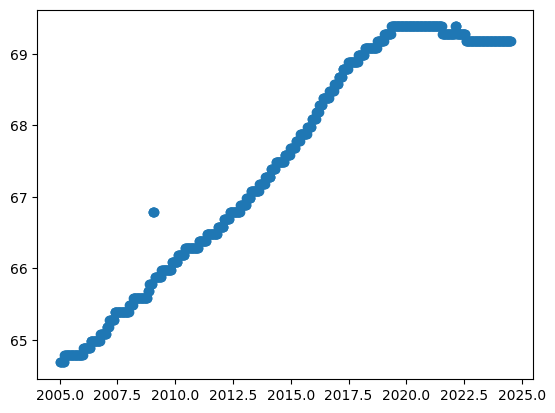

In [5]:
plt.scatter(x_values, y_values)
# Able to notice the outliers in the data

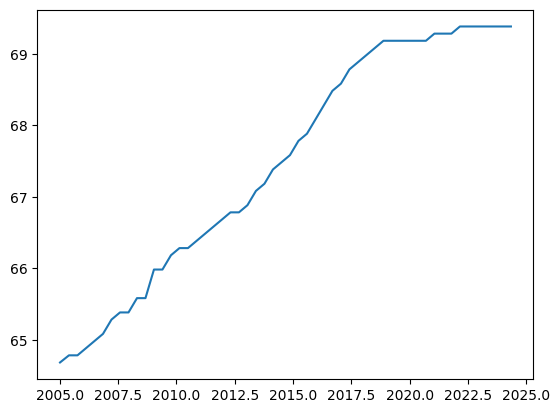

In [6]:
plt.plot(sorted(x_values[::19]), sorted(y_values[::19]))

In [7]:
# Filter out the outliers

import pandas as pd

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

df = pd.DataFrame({'year': x_values, 'delta_t': y_values})

# Polynomial regression and fir the model.
degree = 3 # Simply use degree 3 here just for filtering.
years_poly = PolynomialFeatures(degree).fit_transform(df[['year']])

model = LinearRegression()
model.fit(years_poly, df['delta_t'])

# Predict the values and calculate the residuals.
delta_t_pred = model.predict(years_poly)
residuals = df['delta_t'] - delta_t_pred

# Define a threshold to identify outliers.
# Simply use 2 times the standard deviation of the residuals.
threshold = 2 * np.std(residuals)

# Filter out!
outliers = np.abs(residuals) > threshold
filtered_data = df[~outliers]

5 outliers removed.


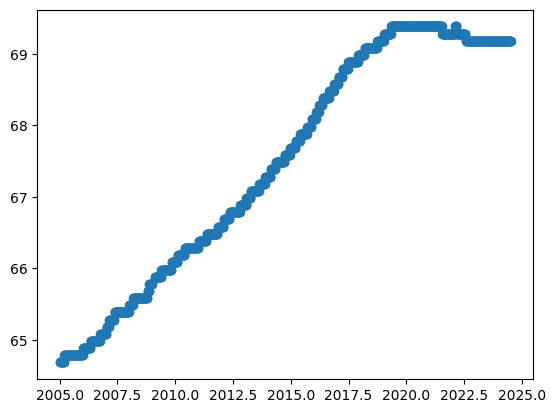

In [8]:
print(f'{len(df) - len(filtered_data)} outliers removed.')

plt.scatter(filtered_data['year'], filtered_data['delta_t'])

In [9]:
# Use scipy to find a polynomial that fits the data!

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, max_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def __poly(x, a, b, c, d, e, f, g, h):
  u = x - 1990
  return a + b / u + c * u + d * u**2 + e * u**3 + f * u**4 + g * u**5 + h * u**6

popt, pcov = curve_fit(__poly, filtered_data['year'], filtered_data['delta_t'])

print(popt)

def poly(x):
  return __poly(x, *popt)

print(f'r2        = {r2_score(filtered_data["delta_t"], poly(filtered_data["year"]))}')
print(f'mse       = {mean_squared_error(filtered_data["delta_t"], poly(filtered_data["year"]))}')
print(f'mae       = {mean_absolute_error(filtered_data["delta_t"], poly(filtered_data["year"]))}')
print(f'mape      = {mean_absolute_percentage_error(filtered_data["delta_t"], poly(filtered_data["year"]))}')
print(f'max_error = {max_error(filtered_data["delta_t"], poly(filtered_data["year"]))}')

[-2.94995860e+03  1.20164739e+04  2.94672466e+02 -1.35156831e+01
  2.34058777e-01  2.99503954e-03 -1.66478197e-04  1.70451579e-06]
r2        = 0.9992751676553152
mse       = 0.001885226297360937
mae       = 0.03481467810664589
mape      = 0.000516857245783325
max_error = 0.15568253632780227


In [10]:
print(f'''
Coefficients:
  a = {popt[0]}
  b = {popt[1]}
  c = {popt[2]}
  d = {popt[3]}
  e = {popt[4]}
  f = {popt[5]}
  g = {popt[6]}
  h = {popt[7]}

Polynomial:
  u = x - 1990
  y = f(u) = {popt[0]} + {popt[1]} / u + {popt[2]} * u + {popt[3]} * u^2 + {popt[4]} * u^3 + {popt[5]} * u^4 + {popt[6]} * u^5 + {popt[7]} * u^6
''')


Coefficients:
  a = -2949.958601922371
  b = 12016.473855893917
  c = 294.67246603408455
  d = -13.515683128588426
  e = 0.23405877703816516
  f = 0.0029950395402493037
  g = -0.00016647819707305944
  h = 1.7045157922909156e-06

Polynomial:
  u = x - 1990
  y = f(u) = -2949.958601922371 + 12016.473855893917 / u + 294.67246603408455 * u + -13.515683128588426 * u^2 + 0.23405877703816516 * u^3 + 0.0029950395402493037 * u^4 + -0.00016647819707305944 * u^5 + 1.7045157922909156e-06 * u^6



Year: 2025, Predicted delta_t: 69.50070814326045
Year: 2026, Predicted delta_t: 70.5383187331945
Year: 2027, Predicted delta_t: 72.75177864796842
Year: 2028, Predicted delta_t: 76.7703490246895
Year: 2029, Predicted delta_t: 83.40044100712748


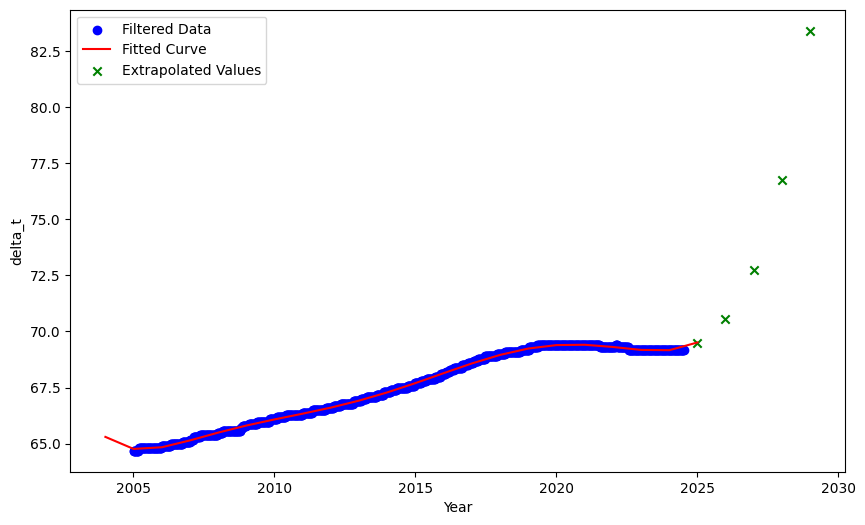

In [11]:
# Use the fitted model to predict the delta_t for future years.

future_years = np.arange(2025, 2030)
predicted_future_delta_t = poly(future_years)

for year, delta_t in zip(future_years, predicted_future_delta_t):
    print(f'Year: {year}, Predicted delta_t: {delta_t}')

# Plot the original data, the fitted curve, and the extrapolated values
plt.figure(figsize=(10, 6))

# Original data points
plt.scatter(filtered_data['year'], filtered_data['delta_t'], color='blue', label='Filtered Data')

# Fitted curve on the original data
years_range = np.arange(filtered_data['year'].min() - 1, filtered_data['year'].max() + 1)
fitted_curve = poly(years_range)
plt.plot(years_range, fitted_curve, color='red', label='Fitted Curve')

# Extrapolated values
plt.scatter(future_years, predicted_future_delta_t, color='green', label='Extrapolated Values', marker='x')

plt.xlabel('Year')
plt.ylabel('delta_t')
plt.legend()
plt.show()

# The fitted model has bad performance on the extrapolated values.

In [12]:
# Ref: https://maia.usno.navy.mil/ser7/deltat.preds

USNO_PREDICTION = '''
MJD	          Year	TT-UT	UT1-UTC	Error
60493.000	2024.50	69.10	 	0.056
60584.000	2024.75	69.03	 	0.070
60675.000	2025.00	69.04	 	0.088
60767.000	2025.25	69.07	 	0.109
60858.000	2025.50	69.06	 	0.133
60949.000	2025.75	69.01	 	0.159
61041.000	2026.00	69.05	 	0.189
61132.000	2026.25	69.09	 	0.223
61223.000	2026.50	69.11	 	0.257
61314.000	2026.75	69.09	 	0.291
61406.000	2027.00	69.14	 	0.327
61497.000	2027.25	69.21		0.367
61588.000	2027.50	69.26		0.408
61680.000	2027.75	69.26		0.446
61771.000	2028.00	69.34		0.486
61862.000	2028.25	69.44		0.525
61954.000	2028.50	69.51		0.566
62045.000	2028.75	69.54		0.603
62136.000	2029.00	69.63		0.637
62228.000	2029.25	69.75		0.672
62319.000	2029.50	69.83		0.711
62410.000	2029.75	69.87		0.742
62502.000	2030.00	69.97		0.768
62593.000	2030.25	70.08		0.794
62684.000	2030.50	70.17		0.823
62775.000	2030.75	70.21		0.849
62867.000	2031.00	70.32		0.871
62958.000	2031.25	70.42		0.891
63049.000	2031.50	70.51		0.913
63141.000	2031.75	70.53		0.926
63232.000	2032.00	70.62		0.937
63323.000	2032.25	70.72		0.952
63415.000	2032.50	70.82		0.975
63506.000	2032.75	70.86		1
63597.000	2033.00	70.98		1
63689.000	2033.25	71.10		1
63780.000	2033.50	71.20		1
63871.000	2033.75	71.25		1
'''

usno_lines = USNO_PREDICTION.strip().splitlines()[1:]

def parse_usno_line(line: str) -> tuple[float, float]:
  line = line.strip()
  splitted = line.split()
  assert len(splitted) in [4, 5]
  year = float(splitted[1])
  delta_t = float(splitted[2])
  return year, delta_t

usno_parsed = list(map(parse_usno_line, usno_lines))
usno_future_years = np.array([year for (year, _) in usno_parsed])
usno_future_delta_t = np.array([delta_t for (_, delta_t) in usno_parsed])

In [13]:
# Use scipy to curve-fit the usno prediction!

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, max_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def __pred_poly(x, a, b, c, d):
  u = x - 2024
  return a + b * u + c * u**2 + d * u**3


pred_popt, _ = curve_fit(__pred_poly, usno_future_years, usno_future_delta_t)

def pred_poly(x: float) -> float:
  return __pred_poly(x, *pred_popt)

print(pred_popt)

scipy_future_delta_t = pred_poly(usno_future_years)

print(f'r2        = {r2_score(usno_future_delta_t, scipy_future_delta_t)}')
print(f'max_error = {max_error(usno_future_delta_t, scipy_future_delta_t)}')
print(f'mse       = {mean_squared_error(usno_future_delta_t, scipy_future_delta_t)}')
print(f'mae       = {mean_absolute_error(usno_future_delta_t, scipy_future_delta_t)}')
print(f'mape      = {mean_absolute_percentage_error(usno_future_delta_t, scipy_future_delta_t)}')

[ 6.91694609e+01 -1.98079611e-01  7.57004778e-02 -3.45554995e-03]
r2        = 0.998599941326388
max_error = 0.05713364889318484
mse       = 0.0007426346541642089
mae       = 0.023551181667687018
mape      = 0.00033671165777883326


In [14]:
print(f'''
Coefficients:
a = {pred_popt[0]}
b = {pred_popt[1]}
c = {pred_popt[2]}
d = {pred_popt[3]}

Polynomial:
u = x - 2024
y = f(u) = {pred_popt[0]} + {pred_popt[1]} * u + {pred_popt[2]} * u^2 + {pred_popt[3]} * u^3
''')


Coefficients:
a = 69.16946091855709
b = -0.1980796111631875
c = 0.07570047780374434
d = -0.003455549953246706

Polynomial:
u = x - 2024
y = f(u) = 69.16946091855709 + -0.1980796111631875 * u + 0.07570047780374434 * u^2 + -0.003455549953246706 * u^3



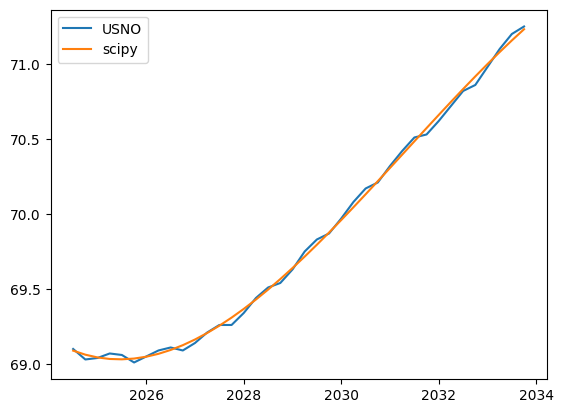

In [15]:
# Plot the results!
plt.plot(usno_future_years, usno_future_delta_t, label='USNO')
plt.plot(usno_future_years, scipy_future_delta_t, label='scipy')
plt.legend()

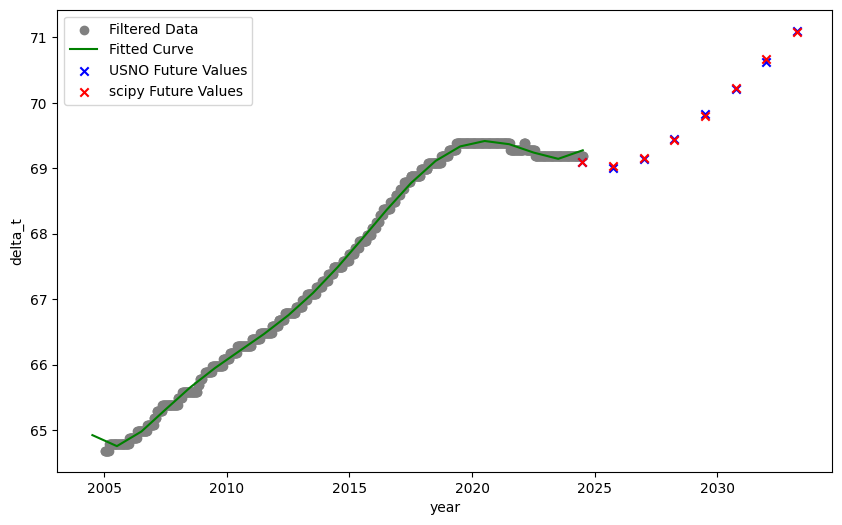

In [16]:
# Plot the original data, the fitted curve, and the future predicted values
plt.figure(figsize=(10, 6))

# Original data points
plt.scatter(filtered_data['year'], filtered_data['delta_t'], color='grey', label='Filtered Data')

# Fitted curve on the original data
years_range = np.arange(filtered_data['year'].min() - 0.5, filtered_data['year'].max() + 0.5)
fitted_curve = poly(years_range)
plt.plot(years_range, fitted_curve, color='green', label='Fitted Curve')

# Future values
plt.scatter(usno_future_years[::5], usno_future_delta_t[::5], color='blue', label='USNO Future Values', marker='x')
plt.scatter(usno_future_years[::5], scipy_future_delta_t[::5], color='red', label='scipy Future Values', marker='x')

plt.xlabel('year')
plt.ylabel('delta_t')
plt.legend()